<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1264216 entries, 0 to 1264215
Data columns (total 7 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   Id            1264216 non-null  int64  
 1   OwnerUserId   1249762 non-null  float64
 2   CreationDate  1264216 non-null  object 
 3   ClosedDate    55959 non-null    object 
 4   Score         1264216 non-null  int64  
 5   Title         1264216 non-null  object 
 6   Body          1264216 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 67.5+ MB
None 

Shape before dropping duplicates for questions_df: (1264216, 7)
Shape after dropping duplicates for questions_df: (1264216, 7)

Shape before dropping duplicates for tags_df: (3750994, 2)
Shape after dropping duplicates for tags_df: (3750993, 2)

Number of Title duplicates: 221
Number of Body duplicates: 12

Number of duplicates in questions_df on Title AND Body: 2
Min score: -73
Max score: 5190


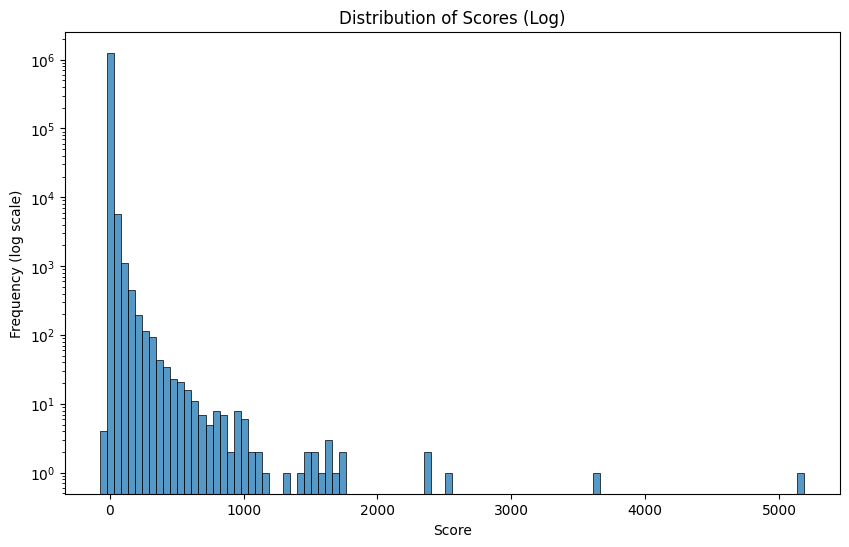

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3750993 entries, 0 to 3750993
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Id      int64 
 1   Tag     object
dtypes: int64(1), object(1)
memory usage: 85.9+ MB
None 

Dropping duplicates of tags_df
Number of unique tags: 37035


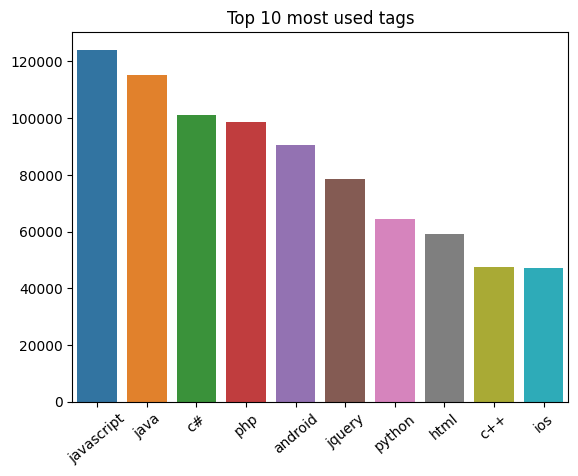

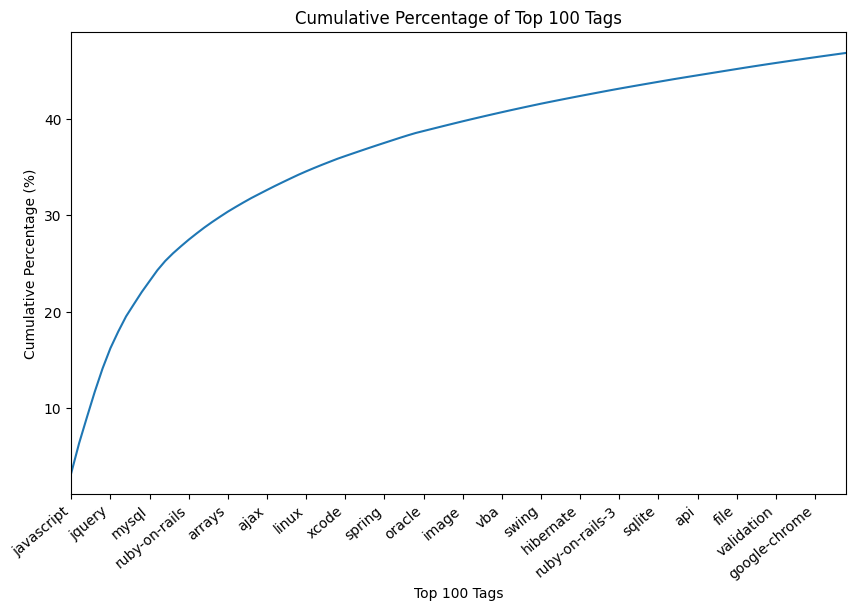

The top 100 tags account for 46.82% of the total tags.


In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import pickle
import contractions
from bs4 import BeautifulSoup
import unicodedata
from collections import Counter
import spacy

# python -m spacy download en_core_web_sm

# Load spacy model
nlp = spacy.load("en_core_web_sm")

project_dir = os.getcwd()

questions_df = pd.read_csv('Questions.csv', encoding='latin1')
tags_df = pd.read_csv('Tags.csv', encoding='latin1')

print(questions_df.info(),'\n')

# print(questions_df.head())

print(f"Shape before dropping duplicates for questions_df: {questions_df.shape}")
questions_df = questions_df.drop_duplicates()
print(f"Shape after dropping duplicates for questions_df: {questions_df.shape}\n")

# same for tags
print(f"Shape before dropping duplicates for tags_df: {tags_df.shape}")
tags_df = tags_df.drop_duplicates()
print(f"Shape after dropping duplicates for tags_df: {tags_df.shape}\n")

# check duplicates on Title
print(f"Number of Title duplicates: {questions_df.duplicated('Title').sum()}") # Different topics can have same titles
# check duplicates on Body
print(f"Number of Body duplicates: {questions_df.duplicated('Body').sum()}\n")

print('Number of duplicates in questions_df on Title AND Body:', questions_df.duplicated(subset=['Body', 'Title']).sum())
# drop those
questions_df = questions_df.drop_duplicates(subset=['Body', 'Title'])

# print min and max
print(f"Min score: {questions_df.Score.min()}")
print(f"Max score: {questions_df.Score.max()}")

plt.figure(figsize=(10, 6))

# Using a log scale for the y-axis
sns.histplot(questions_df['Score'], bins=100, log_scale=(False, True))  # Adjust the bins count as needed
plt.title('Distribution of Scores (Log)')
plt.xlabel('Score')
plt.ylabel('Frequency (log scale)')
plt.show()

# High Frequency of Low Scores: There's a very high frequency of scores that are close to zero, as indicated by the tall bar at the left side of the histogram.
# Rapid Drop-off: As we move right on the x-axis (increasing score), the frequency of scores decreases rapidly.
# Sparse High Scores: There are very few high scores, as evidenced by the bars becoming shorter and more spaced out as the score increases.

# Focus on questions with scores that might indicate a higher community interest or better quality, filtering out scores below 5 could remove a large portion of the data that is less significant in terms of score.

print(tags_df.info(),'\n')
# tags_df.head()
print(f'Dropping duplicates of tags_df')
tags_df = tags_df.drop_duplicates()

tag_value_counts = tags_df['Tag'].value_counts()
unique_tags = tags_df["Tag"].unique()
print(f"Number of unique tags: {len(unique_tags)}")
# Too many unique tags

top_ten_tags = tag_value_counts.head(10)
sns.barplot(x=top_ten_tags.index, y=top_ten_tags.values)
plt.xticks(rotation=40)
plt.title('Top 10 most used tags')
plt.show()

all_tags = tags_df['Tag'].explode()
tag_counts = all_tags.value_counts()

# Calculate the cumulative percentage
cumulative_percentage = 100 * tag_counts.cumsum() / tag_counts.sum()

# Reset the index to turn the data into a DataFrame suitable for seaborn
cumulative_percentage_T_df = cumulative_percentage.reset_index()
cumulative_percentage_T_df.columns = ['Tag', 'Cumulative Percentage']

# Plot the cumulative percentage of the top 100 tags
plt.figure(figsize=(10, 6))
sns.lineplot(x='Tag', y='Cumulative Percentage', data=cumulative_percentage_T_df.head(100))

tick_positions = range(0, 100, 5)  # Positions every 5 labels
tick_labels = cumulative_percentage_T_df['Tag'].iloc[::5].head(20)  # Select every 5th label
plt.xticks(ticks=tick_positions, labels=tick_labels, rotation=40, ha="right")

plt.margins(x=0)
plt.xlabel('Top 100 Tags')
plt.ylabel('Cumulative Percentage (%)')
plt.title('Cumulative Percentage of Top 100 Tags')

plt.show()

top_100_coverage = cumulative_percentage.head(100).iloc[-1]
print(f"The top 100 tags account for {top_100_coverage:.2f}% of the total tags.")

Minimum of 1 tag.
Maximum of 5 tags.
Average of 2.97 tags per question.


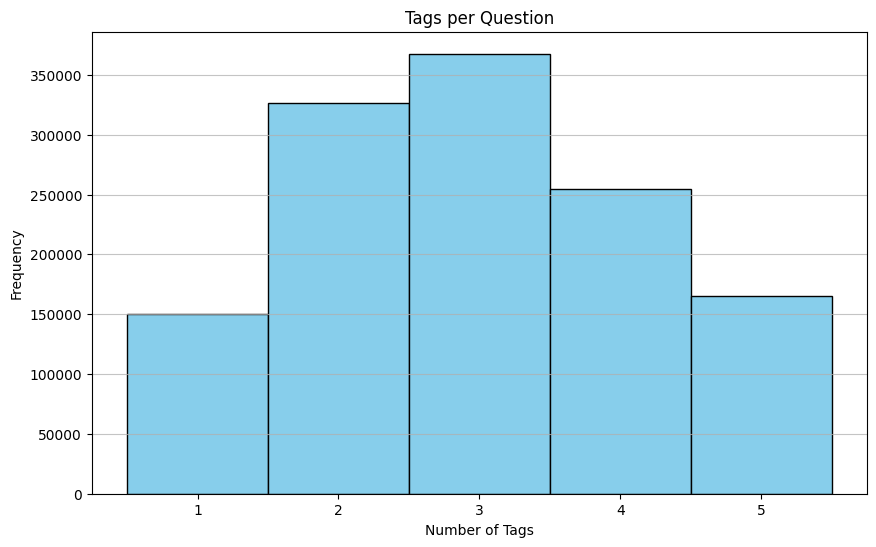

Shape of df: (1264214, 6)
Shape of df after filtering based on Score: (93152, 6)


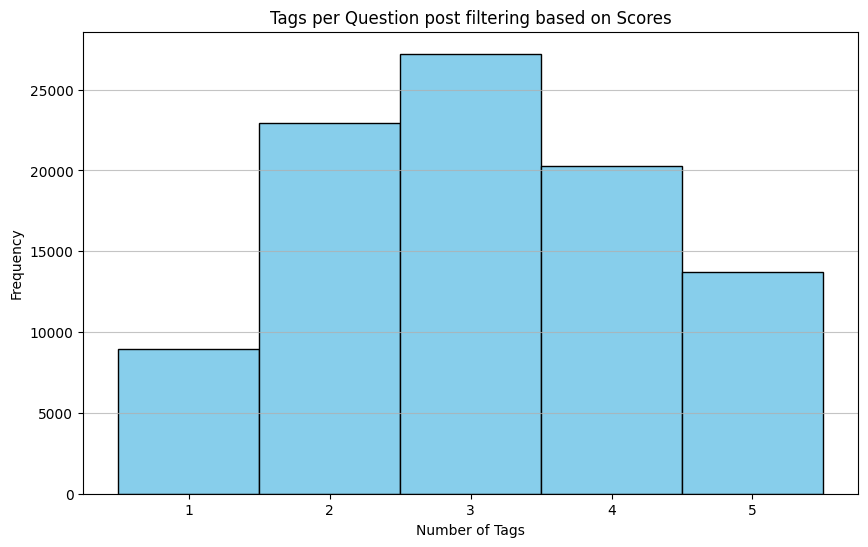

In [2]:
# group rows per question id
tags_per_question_df = tags_df.groupby(['Id'])['Tag'].apply(list)

# we are only interested in text column(s) from `questions_main_df`
main_df = questions_df[["Id", "Title", "Body", "Score"]].merge(tags_per_question_df.to_frame(), on="Id")

main_df["Tag_count"] = main_df["Tag"].apply(len)

print(f"Minimum of {main_df.Tag_count.min()} tag.")
print(f"Maximum of {main_df.Tag_count.max()} tags.") 
print(f"Average of {main_df.Tag_count.mean():.2f} tags per question.")

# Plot the distribution of tag counts

plt.figure(figsize=(10, 6))
plt.hist(main_df["Tag_count"], bins=range(1, main_df["Tag_count"].max() + 2), align='left', color='skyblue', edgecolor='black')
plt.title('Tags per Question')
plt.xlabel('Number of Tags')
plt.ylabel('Frequency')
plt.xticks(range(1, main_df["Tag_count"].max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()


### FILTERING BASED ON SCORE

# We will be filtering the questions based on score as I believe that low score questions are less likely to be useful for our analysis. Also, negative scores may indicate that the question is not useful or is not well written.
# Filter to only include questions with a score of 5 or higher

# print shape
print(f"Shape of df: {main_df.shape}")
# Filter out scores less than 5
main_df = main_df[main_df['Score'] >= 5]
print(f"Shape of df after filtering based on Score: {main_df.shape}")

# Plot the distribution of tag counts
plt.figure(figsize=(10, 6))
plt.hist(main_df["Tag_count"], bins=range(1, main_df["Tag_count"].max() + 2), align='left', color='skyblue', edgecolor='black')
plt.title('Tags per Question post filtering based on Scores')
plt.xlabel('Number of Tags')
plt.ylabel('Frequency')
plt.xticks(range(1, main_df["Tag_count"].max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [5]:
# ------------------------------------------------------------- TEXT SANITIZATION



# Calculate the lengths of each 'Title' and 'Body'
title_length = main_df['Title'].str.len()
body_length = main_df['Body'].str.len()

# Output the minimum and maximum lengths
print(f"Shortest Title: {title_length.min()}, Longest Title: {title_length.max()}")
print(f"Shortest Body: {body_length.min()}, Longest Body: {body_length.max()}")

# Identify the entries with the shortest and longest titles
# shortest_title_entries = main_df[title_length == title_length.min()]
# longest_title_entries = main_df[title_length == title_length.max()]

# Display the entries
# print(shortest_title_entries)
# print(longest_title_entries)

# Identify and display the entries with the shortest and longest bodies
# shortest_body_entries = main_df[body_length == body_length.min()]
# longest_body_entries = main_df[body_length == body_length.max()]

# shortest_body_entries
# longest_body_entries

# Filter to only keep 100 most common tags

n_of_classes = 100 

# Flatten the list of all tags in the dataset
flat_list = [tag for sublist in main_df['Tag'] for tag in sublist]

# Calculate the frequency of each tag and select the top n_of_classes
counter = Counter(flat_list)
most_common_tags = [tag for tag, _ in counter.most_common(n_of_classes)]

# Define a filter function
def filter_tags(tags):
    return [tag for tag in tags if tag in most_common_tags]

# Apply the filter function to each row in the dataframe
main_df['Tag'] = main_df['Tag'].apply(filter_tags)

# check how many are empty lists now
print(f"\nRows that have no tags after filtering for top {n_of_classes} tags: {main_df[main_df['Tag'].apply(len) == 0].shape[0]} -> dropping those")
# drop them
main_df = main_df[main_df['Tag'].apply(len) > 0]

def remove_html_tags_using_bs(html_text):
    return BeautifulSoup(html_text, "html.parser").get_text()

def remove_accents(text):
    text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('utf-8')
    return text

def lemmatize_text(text):
    # Process the text using the model
    doc = nlp(text)
    # Extract the lemma for each token and join / only if its not pron or -PRON-
    lemmatized_text = " ".join([token.lemma_ if token.lemma_ != "-PRON-" else token.text for token in doc])
    return lemmatized_text


# For classifying text to identify programming languages, lemmatization is preferable due to:

# Accuracy: It maintains the semantic meaning of technical terms crucial for distinguishing programming languages.
# Precision: Lemmatization preserves linguistic distinctions by considering context and grammatical structure, aiding in accurate classification.
# Consistency: It provides consistent base forms for words, improving machine learning model performance.
# Context Understanding: Better handles varied programming-related texts by understanding grammatical nuances.
# Lemmatization's ability to accurately interpret and process language-specific details makes it more suited for tasks requiring high precision, such as classifying texts into programming languages.

def blender_clean(df, column_name):
    # remove html tags
    df[column_name] = df[column_name].apply(remove_html_tags_using_bs)
    # apply contraction fixes
    df[column_name] = df[column_name].apply(lambda x: contractions.fix(x))
    # remove accents
    df[column_name] = df[column_name].apply(remove_accents)
    # lemmatize text
    df[column_name] = df[column_name].apply(lemmatize_text)
    # remove extra whitespace
    df[column_name] = df[column_name].apply(lambda x: re.sub(' +', ' ', x))

    return df

Shortest Title: 0, Longest Title: 172
Shortest Body: 25, Longest Body: 31291

Rows that have no tags after filtering for top 100 tags: 0 -> dropping those


In [4]:
print('Now starting process to clean the text')

main_df = blender_clean(main_df, "Title")
print('Title cleaning done')
main_df = blender_clean(main_df, "Body")
print('Body cleaning done')

#pandas to pickle
main_df.to_pickle(f"{project_dir}\\main_df_after_sanitization.pkl")

Now starting process to clean the text


c:\Users\Nick\anaconda3\envs\C4P\lib\site-packages\bs4\__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


KeyboardInterrupt: 